In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import drawbox
%matplotlib inline

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from process import *
import mod

In [3]:
average_size = 0
for row in df.iterrows():
    average_size += (row[1][2] * row[1][3])
average_size /= len(df)
print(average_size)


81765.96890311324


In [8]:
os.listdir('../samples/testing/videos/')

['large2.mp4',
 'large3.mp4',
 'large4.mp4',
 'large5.mp4',
 'largefast.mp4',
 'largeslow.mp4',
 'largeslow2.mp4',
 'medium.mp4',
 'noisy.mp4',
 'smallfast.mp4',
 'smallslow.mp4',
 'smallslow2.mp4',
 'sparse.mp4']

In [10]:
videos = '../samples/testing/videos/'
for res in [(1280, 720), (960, 540), (640, 360)]:
    for video in list(os.listdir(videos)):
        print(video)
        output = mod.run(
            yolov5_model='yolov5n',
            img_width=res[0],
            img_height=res[1],
            fps=25,
            frame_cap=250,
            conf=0.6,
            video_path='../samples/testing/videos/',
            video_source=video.split('.')[0],
            out_path=''
        )
        output.to_csv(f'./resolution/{video.split(".")[0]}_{res[0]}_{res[1]}_25_inference.csv')



Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 


large2.mp4


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, c

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



      xcenter    ycenter       width    height  confidence  class  name
0  819.903809  472.06424  177.017212  223.4245    0.826782     21  bear
save failed
frames: 250
runtime (inference): 66.79483413696289
average time per frame: 0.2671793365478516
confidence: 0.6
large3.mp4


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
      xcenter     ycenter       width      height  confidence  class name
0  763.624512  536.901978  205.683594  293.713348    0.611978     16  dog
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
      xcenter     ycenter       width      height  confidence  class name
0  768.380615  540.046143  199.154053  294.919678    0.608774     16  dog
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
Empty DataFrame
Columns: [xcenter, ycenter, wi

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


     xcenter     ycenter       width      height  confidence  class  name
0  802.79895  410.769257  279.462402  188.582581    0.849404     21  bear
     xcenter     ycenter       width      height  confidence  class  name
0  800.77771  412.238068  276.355957  194.271301    0.784601     21  bear
      xcenter     ycenter       width      height  confidence  class  name
0  797.927856  404.440796  296.771729  184.993652    0.855469     21  bear
      xcenter     ycenter       width      height  confidence  class  name
0  795.256958  404.602661  293.245117  187.024536    0.873752     21  bear
      xcenter     ycenter       width     height  confidence  class  name
0  791.970947  408.002655  294.471191  194.25531    0.897627     21  bear
      xcenter    ycenter       width      height  confidence  class  name
0  789.085144  406.50235  293.669189  194.294067    0.901468     21  bear
      xcenter     ycenter       width      height  confidence  class  name
0  785.693237  405.704407  298.65

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


      xcenter     ycenter      width     height  confidence  class name
0  552.550659  607.211731  56.124512  58.999878    0.767848      2  car
1  647.667175  614.224854  74.165161  45.554077    0.695223      2  car
      xcenter     ycenter      width     height  confidence  class name
0  552.347900  606.835205  56.459229  59.727661    0.750483      2  car
1  647.365967  614.737000  74.356079  45.467651    0.645766      2  car
      xcenter     ycenter      width     height  confidence  class name
0  551.738892  606.618042  57.769531  60.716797    0.790721      2  car
1  647.581360  614.334534  77.478638  45.296509    0.681490      2  car
2  794.342529  615.622070  85.130127  55.051392    0.630383      2  car
      xcenter     ycenter      width     height  confidence  class name
0  551.325745  605.448486  59.235352  63.096313    0.814256      2  car
1  648.836182  613.763733  76.135010  46.978516    0.696954      2  car
2  793.879517  615.635620  87.265015  54.897827    0.666305     

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


       xcenter     ycenter       width      height  confidence  class name
0  1115.663574  323.206879  326.264099  129.916077    0.790414      2  car
       xcenter    ycenter       width     height  confidence  class name
0  1106.742798  323.31897  345.199463  125.86615    0.838485      2  car
       xcenter     ycenter       width     height  confidence  class name
0  1097.823242  323.582245  364.353516  129.36908    0.789011      2  car
       xcenter     ycenter       width      height  confidence  class name
0  1082.865967  324.427612  392.783691  130.050293    0.816928      2  car
       xcenter     ycenter       width      height  confidence  class name
0  1067.287842  324.227814  395.439453  128.816284    0.803568      2  car
       xcenter    ycenter       width     height  confidence  class name
0  1042.154541  323.70343  415.193359  129.16803    0.621386      2  car
       xcenter     ycenter       width      height  confidence  class name
0  1020.493835  324.828827  418.171

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []
save failed
frames: 250
runtime (inference): 67.02051281929016
average time per frame: 0.26808205127716067
confidence: 0.6
largeslow.mp4


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


      xcenter     ycenter      width     height  confidence  class    name
0  263.251923  168.878403  60.385925  163.39682    0.740639      0  person
      xcenter     ycenter      width      height  confidence  class    name
0  263.658905  169.683838  59.275757  161.436768    0.740352      0  person
      xcenter     ycenter      width      height  confidence  class    name
0  266.853516  171.854202  57.862564  152.442596    0.630145      0  person
      xcenter     ycenter      width      height  confidence  class    name
0  267.735931  171.493683  57.094193  154.408813    0.654082      0  person
      xcenter     ycenter      width      height  confidence  class    name
0  269.775848  172.929794  61.708542  152.303741    0.720278      0  person
     xcenter     ycenter      width      height  confidence  class    name
0  271.87323  162.669617  59.549515  173.476929    0.751634      0  person
      xcenter     ycenter       width      height  confidence  class      name
0  272.127258

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



       xcenter     ycenter       width      height  confidence  class  \
0  1232.584229   72.715286   93.092773  145.430573    0.831993      2   
1   705.888367  387.152863  130.456665  114.907654    0.633371      4   

       name  
0       car  
1  airplane  
save failed
frames: 250
runtime (inference): 68.44013237953186
average time per frame: 0.27376052951812746
confidence: 0.6
largeslow2.mp4


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


       xcenter     ycenter       width      height  confidence  class name
0   368.811218  292.757263  244.282288  106.427170    0.917727      2  car
1   699.492310  292.421112  286.688843  111.764099    0.798398      2  car
2   455.557037  222.752350  140.753479   61.769119    0.780488      2  car
3   195.712128  410.087585  155.821228  128.500122    0.754753      2  car
4   164.630951  267.293152  121.265137   84.097061    0.696902      2  car
5  1001.763794  198.443085  108.629395   43.527222    0.627710      2  car
       xcenter     ycenter       width      height  confidence  class name
0   367.317352  292.617493  249.341980  106.274429    0.919723      2  car
1   701.307434  294.314148  278.379761  110.635971    0.819838      2  car
2   455.856110  222.693726  139.651428   61.629395    0.762172      2  car
3   198.428040  409.483948  160.951294  127.560852    0.679395      2  car
4   164.114426  266.174377  122.640045   81.880066    0.647394      2  car
5  1000.757080  198.74177

Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


      xcenter     ycenter       width      height  confidence  class   name
0  306.224121  469.011658  277.887024  124.465698    0.647475      7  truck
     xcenter     ycenter       width      height  confidence  class   name
0  306.03949  469.174255  277.319214  124.862671    0.642605      7  truck
      xcenter    ycenter       width      height  confidence  class   name
0  316.579956  469.08078  277.824707  125.901794    0.692273      7  truck
      xcenter     ycenter       width      height  confidence  class   name
0  321.539062  469.078491  273.270386  122.440643    0.647797      7  truck
      xcenter     ycenter       width      height  confidence  class   name
0  335.561218  470.450256  274.132446  120.955322    0.689265      7  truck
      xcenter     ycenter       width      height  confidence  class   name
0  345.505798  469.301514  273.305908  120.702759    0.692448      7  truck
Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: [

KeyboardInterrupt: 

In [3]:
drawbox.run('../samples/testing/ground_truth/smallslow_n.csv', '../samples/testing/ground_truth/smallslow_n.csv', '../samples/testing/videos/smallslow.mp4', './temp.mp4', False, None, 'None', None)

In [3]:
cap = cv2.VideoCapture('temp.mp4')
frame_no = 0
frame = None
while frame_no < 250:
    ret, frame = cap.read()
    if frame_no == 200:
        break
    frame_no += 1
    

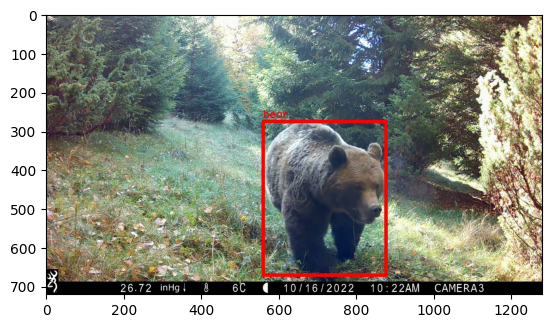

In [4]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA))

In [5]:
cv2.imwrite('temp.png', frame)

True

In [39]:
def process_inf(width, height, df, num_frames, get_gt):
    preds_list = []
    
    # Normalize values
    df.xcenter /= width
    df.ycenter /= df['ycenter'].div(height)

    # Loop through the frame numbers in df
    for i in range(1, num_frames+1):
        
        # Filter df for just the rows corresponding to current frame
        current_frame_df = df[df['frame'] == i]
        current_frame_df = current_frame_df.sort_values(by=['class', 'xcenter'], ascending=True)

        # Create FloatTensor containing boxes
        bbox_cols = current_frame_df[['xcenter', 'ycenter', 'width', 'height']]
        boxes = torch.tensor(bbox_cols.values)
        
        # Create IntTensor containing labels
        labels = torch.tensor(current_frame_df['class'].tolist())
                
        # Append dict with boxes, labels, and scores to the list
        if get_gt:
            frame_dict = {
                'boxes':boxes,
                'labels':labels
                }
        else:
            scores = torch.tensor(current_frame_df['confidence'].tolist())
            frame_dict = {
                'boxes': boxes,
                'labels': labels,
                'scores': scores
                }
             
        preds_list.append(frame_dict)
        
    return preds_list

def calculate_accuracy(ground_truth, prediction):
    metric = MeanAveragePrecision(box_format='cxcywh', iou_type="bbox")
    metric.update(prediction, ground_truth)
    result = metric.compute()
    return result['map'].item()
